In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# Loading and Pre-processing

In [106]:
sampled_cities_info_path = pathlib.Path("../../data/POC2_data/sampled_cities/info.csv")
sampled_cities_df = pd.read_csv(sampled_cities_info_path)

In [107]:
len(sampled_cities_df.columns)

103

In [108]:
is_na = sampled_cities_df.isna().sum()
is_na[is_na > 0]

6way_int_count       7
6way_int_prop        7
7way_int_count     182
8way_int_count     267
9way_int_count     291
7way_int_prop      182
8way_int_prop      267
9way_int_prop      291
10way_int_count    296
10way_int_prop     296
11way_int_count    298
11way_int_prop     298
12way_int_count    298
13way_int_count    300
14way_int_count    300
15way_int_count    300
16way_int_count    300
17way_int_count    300
18way_int_count    300
19way_int_count    300
20way_int_count    300
21way_int_count    300
22way_int_count    300
23way_int_count    300
24way_int_count    300
25way_int_count    300
26way_int_count    300
27way_int_count    300
28way_int_count    300
12way_int_prop     298
13way_int_prop     300
14way_int_prop     300
15way_int_prop     300
16way_int_prop     300
17way_int_prop     300
18way_int_prop     300
19way_int_prop     300
20way_int_prop     300
21way_int_prop     300
22way_int_prop     300
23way_int_prop     300
24way_int_prop     300
25way_int_prop     300
26way_int_p

In [109]:
#must have at least 100 non-NAs
sampled_cities_df.dropna(thresh=100, axis=1, inplace=True)
sampled_cities_df.fillna(0, inplace=True)

In [110]:
len(sampled_cities_df.columns)

61

In [111]:
obj_cols = sampled_cities_df.dtypes[sampled_cities_df.dtypes == 'object'].index.tolist()
obj_cols

['country',
 'country_iso',
 'core_city',
 'uc_names',
 'world_region',
 'world_subregion']

In [112]:
sampled_cities_df.drop(obj_cols, axis=1, inplace=True)

In [113]:
int_cols = sampled_cities_df.dtypes[sampled_cities_df.dtypes == 'int'].index.tolist()
int_cols

['uc_id',
 'intersect_count',
 'intersect_count_clean',
 'intersect_count_clean_topo',
 'street_segment_count',
 'node_count',
 'resident_pop',
 '1way_int_count',
 '2way_int_count',
 '3way_int_count',
 'planned']

In [114]:
sampled_cities_df.drop('uc_id', axis=1, inplace=True)

In [115]:
len(sampled_cities_df.columns)

54

# Predicting

In [116]:
y = sampled_cities_df['planned'].to_numpy()
X = sampled_cities_df.drop('planned', axis=1).to_numpy()

In [117]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)

In [118]:
d_train = lgb.Dataset(X_train, label=y_train)

In [119]:
grid_params = {
        'learning_rate': (0.1, 0.05, 0.03, 0.01, 0.001),
        'boosting_type': ('gbdt', 'dart', 'goss'),
        'objective': ['binary'],
        'metric':['auc'],
        'num_leaves':(100, 200, 300),
        'max_depth': (50, 100, 200, 300, -1),
        'subsample_for_bin': (10, 20, 30, 50),
        'n_estimators': (50, 100, 200, 300),
        'random_state': [RANDOM_STATE],
    }

In [120]:
lgb_model = lgb.LGBMClassifier()
clf = GridSearchCV(lgb_model, grid_params, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ('gbdt', 'dart', 'goss'),
                         'learning_rate': (0.1, 0.05, 0.03, 0.01, 0.001),
                         'max_depth': (50, 100, 200, 300, -1),
                         'metric': ['auc'], 'n_estimators': (50, 100, 200, 300),
                         'num_leaves': (100, 200, 300), 'objective': ['binary'],
                         'random_state': [42],
                         'subsample_for_bin': (10, 20, 30, 50)},
             verbose=1)

In [121]:
print(f"best_params: {clf.best_params_}")
print(f"best_score: {clf.best_score_}")

best_params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 50, 'metric': 'auc', 'n_estimators': 200, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42, 'subsample_for_bin': 50}
best_score: 0.9625


In [122]:
y_pred = clf.predict(X_test)

Text(0.5, 1.0, 'Matriz de confusão (1= planejada)')

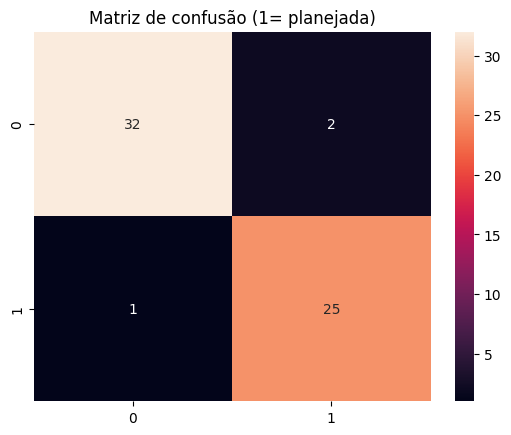

In [123]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title("Matriz de confusão (1= planejada)")

In [124]:
print("Acc: ", accuracy_score(y_test, y_pred))
print("AUC: ", roc_auc_score(y_test, y_pred))

Acc:  0.95
AUC:  0.9513574660633485


# Explicando

In [125]:
import shap

In [126]:
shap.initjs()

In [127]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(sampled_cities_df.drop('planned', axis=1))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


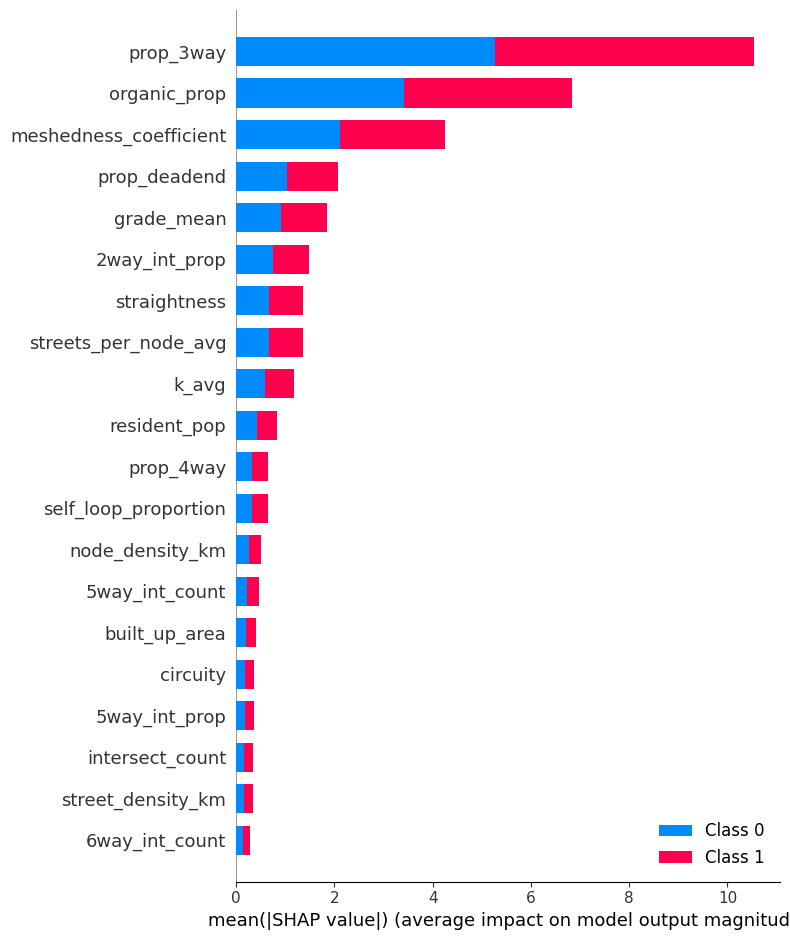

In [128]:
shap.summary_plot(shap_values, sampled_cities_df.drop('planned', axis=1))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


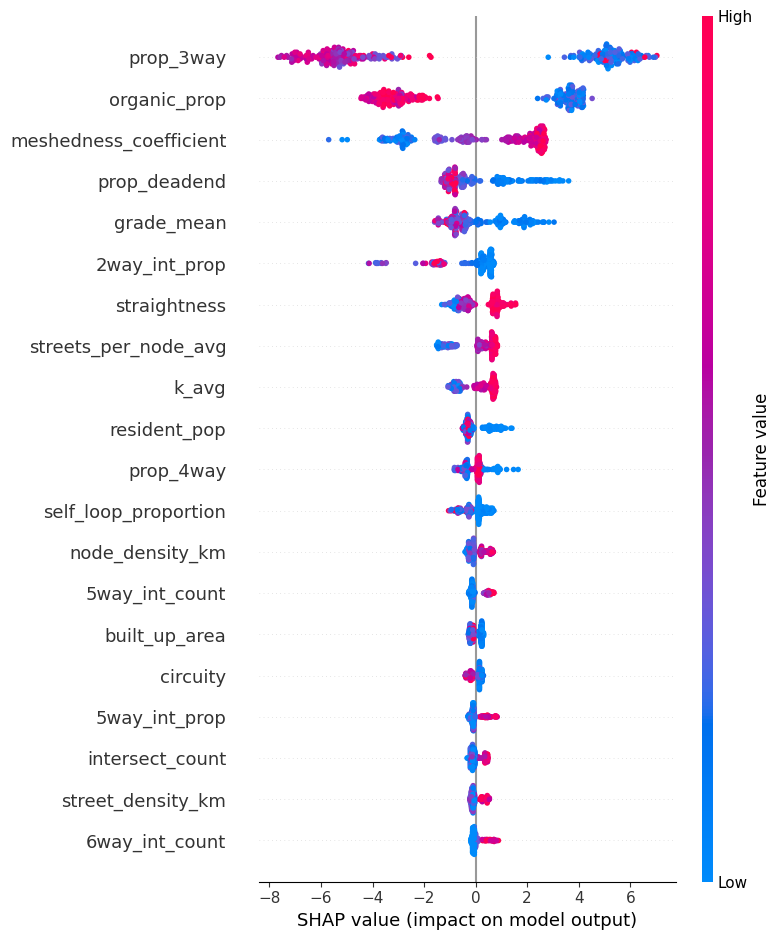

In [130]:
# shap.plots.beeswarm(shap_values[1], plot_size = 1.8, max_display = 13)
shap.summary_plot(shap_values[1], sampled_cities_df.drop('planned', axis=1))

Para o modelo, são mais importantes as seguintes características das cidades:
- prop_3way
- organic_prop
- meshedness_coefficient
- prop_deadend
- grade_mean
- 2way_int_prop
- straightness
- streets_per_node_avg
- k_avg

organic_prop e meshedness_coefficient são duas das 3 características utilizadas para classificar manualmente as cidades. Interessante perceber que prop_3way parece ser mais importante. Circuity foi outra variável utilizada para classificar mas, como straightness está muito ligado a circuity, essa variável, provavelmente, foi utilizada como proxy para circuity.